In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import genfromtxt
from scipy.optimize import linprog
plt.rcParams['figure.figsize'] = [10, 10]

### Generating Data
Here, I generate 2D data as follows: $x_i \sim N(0, 1)$
Then, I arbitrarily generate $w$ and $b$, the underlying model for classifying the data points. The rule for classification is:
$$\langle w, x_i \rangle + b < 0 \Rightarrow y_i = -1$$
$$\langle w, x_i \rangle + b > 0 \Rightarrow y_i = +1$$

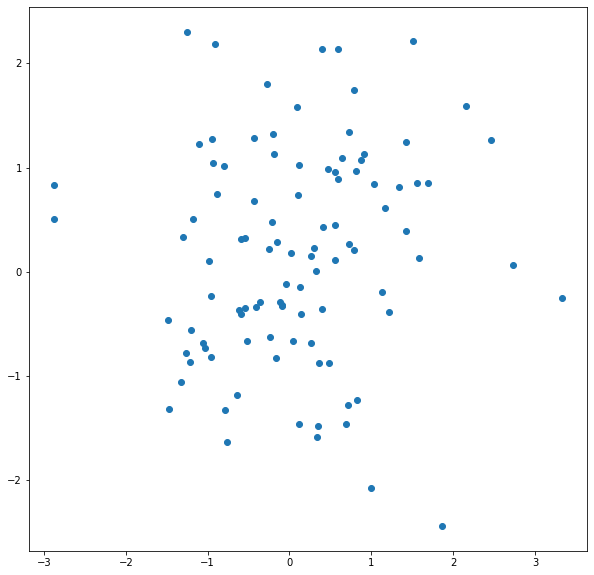

In [2]:
data = np.random.multivariate_normal(np.zeros(2), np.identity(2), 100)
plt.scatter(data[:, 0], data[:, 1])

In [3]:
w = np.random.normal(0, 1, 2)
b = np.random.normal(0, 1, 1)[0]
w, b

(array([-0.07300966, -0.35246455]), -0.054796790946571215)

In [4]:
def color(x):
    return 1 if np.dot(x, w) + b > 0 else -1

In [5]:
c = np.apply_along_axis(color, 1, data)
c

array([-1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1,
        1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1,
        1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1,  1,
        1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,
       -1, -1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1])

In [6]:
data = np.concatenate((data, c.reshape(-1, 1)), axis=1)
data[0:5]

array([[ 1.03054428,  0.84556816, -1.        ],
       [-0.98606222,  0.10252   , -1.        ],
       [ 1.21520432, -0.38770703, -1.        ],
       [ 1.55900985,  0.85563537, -1.        ],
       [ 2.46568465,  1.26496411, -1.        ]])

In [7]:
def color_to_string(x):
    if x == 1: return "r"
    else: return "b"
np.vectorize(color_to_string)(data[:,2])

array(['b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'b', 'r', 'b',
       'r', 'r', 'b', 'r', 'r', 'b', 'r', 'b', 'b', 'r', 'b', 'b', 'b',
       'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'r',
       'r', 'r', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'r', 'b', 'b', 'r',
       'b', 'b', 'r', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'r', 'b',
       'r', 'b', 'r', 'r', 'r', 'r', 'b', 'b', 'r', 'b', 'b', 'r', 'b',
       'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'b', 'b',
       'b', 'r', 'b', 'b', 'b', 'r', 'b', 'b', 'r'], dtype='<U1')

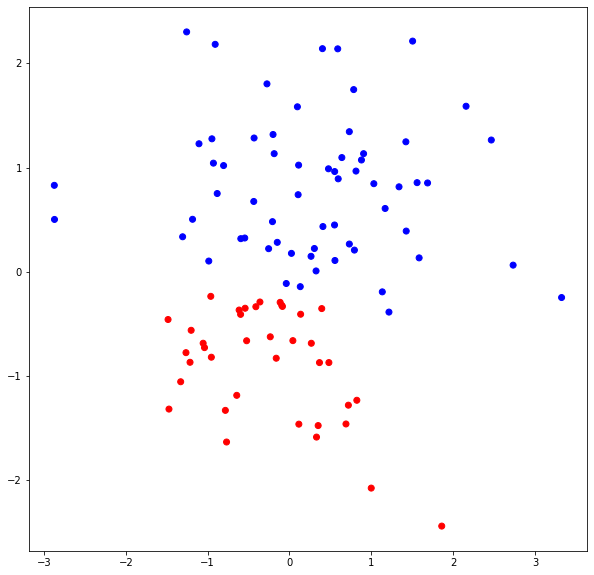

In [8]:
plt.scatter(data[:,0], data[:,1], c=np.vectorize(color_to_string)(data[:,2]))

### Linearly Separable SVM
The key idea is to find $w$ and $b$ such that we can use the hyperplane $\langle w, x \rangle + b = 0$ to separate the data. All the data $(x_i, y_i)$ with label $y_i = +1$ should satisfy $\langle w, x_i \rangle + b \geq 1$. All the data with label $y_i = -1$ should satisfy $\langle w, x_i \rangle + b \leq -1$.

The width of this margin is then $\frac{2}{\| w \|_2^2}$.

Hence, linearly separable SVM can be written as an optimization problem:
$$\text{min}_{w,b} \| w \|_2^2 $$
subject to: $\langle w, x_i \rangle + b \geq 1 \forall \{(x_i,y_i) | y_i = +1\}$ and $\langle w, x_i \rangle + b \leq -1 \forall \{(x_i,y_i) | y_i = -1\}$

The constraints can be collected into the standard form $-y_i(\langle w, x_i \rangle + b) + 1 \leq 0$

In [9]:
what = cp.Variable(2)
bhat = cp.Variable(1)

objective = cp.Minimize(cp.sum_squares(what))
constraints = []
for i in range(len(data)):
    yi = data[i][2]
    xi = data[i][0:2]
    constraints += [-yi*(xi[0]*what[0] + xi[1]*what[1] + bhat) + 1 <= 0]

In [10]:
problem = cp.Problem(objective, constraints)
result = problem.solve()
what.value, bhat.value

(array([ -3.0015079 , -13.78332479]), array([-2.69644658]))

### Results

In [11]:
def res(x):
    grad = -(what.value[0]/what.value[1])
    yinter = - bhat.value/what.value[1]
    return grad*x + yinter

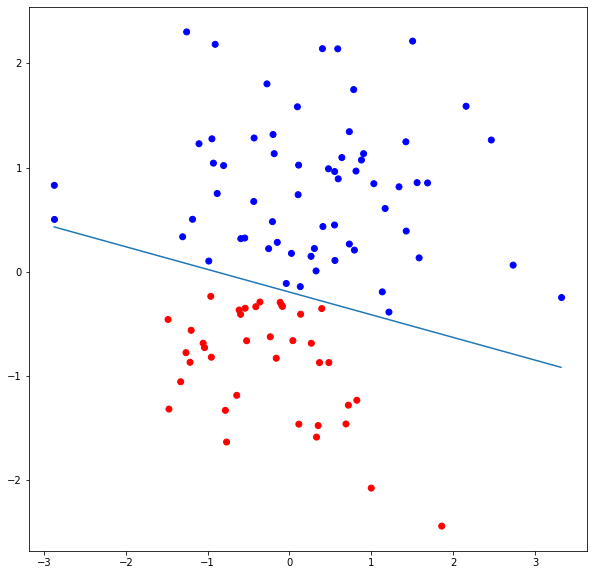

In [12]:
plt.scatter(data[:,0], data[:,1], c=np.vectorize(color_to_string)(data[:,2]))
t = np.arange(np.min(data[:, 0]), np.max(data[:, 0]), 0.01)
plt.plot(t, np.vectorize(res)(t))